OpenGAN: Open-Set Recognition via Open Data Generation
================
**Supplemental Material for ICCV2021 Submission**


In this notebook, we demonstrate how we train the GAN-fea model on the TinyImageNet train-set, providing the closed-set images.

import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [2]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform
import numpy as np
import pandas as pd
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torchvision import transforms as T

from typing import Collection

from utils.eval_funcs import *
from utils.dataset_tinyimagenet import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)


manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/home/zullich/giovanni/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
1.11.0
Random Seed:  999


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [3]:
# set the random seed
torch.manual_seed(0)

################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

modelFlag = 'Punzoni'

project_name = 'OpenGANFull' + modelFlag   # we save all the checkpoints in this directory

# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'


total_epoch_num = 500 # total number of epoch in training
batch_size = 128    

newsize = (64, 64)


path_to_feats = './feats' # the path to cached off-the-shelf features
pklName = path.join(path_to_feats, modelFlag.lower()+'.pkl')



# For GAN-fea, we set the hyper-parameters as below.

# Number of channels in the training images. For color images this is 3
nc = 512

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1



# TinyImageNet has 200 classes.
nClassTotal = 200
nClassCloseset = nClassTotal

#project_name += '_K{}run{}'.format(nClassCloseset, runIdx)
if not os.path.exists(exp_dir): os.makedirs(exp_dir)


num_epochs = total_epoch_num
torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/OpenGANFullPunzoni


Define model architecture
---------

Here is the definition of the model architectures for generator and discriminator. Both are multi-layer perceptron (MLP) networks.

In [63]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)     
        

class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=64, nc=512):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.Conv2d( self.nz, self.ngf * 8, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d( self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d( self.ngf * 2, self.ngf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d( self.ngf*4, self.nc, 1, 1, 0, bias=True),
            #nn.Tanh()
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nc=512, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

class DiscriminatorFunnel(nn.Module):
    def __init__(self, ngpu=1, nc=512, ndf=64):
        super(DiscriminatorFunnel, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 3, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 3, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 3, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 2, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## initialize the networks

In [64]:
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)
netD = DiscriminatorFunnel(ngpu=ngpu, nc=nc, ndf=ndf).to(device)

# Handle multi-gpu if desired
if ('cuda' in device) and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


if ('cuda' in device) and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(device)

cuda:0


## Sanity Check

In [48]:
noise = torch.randn(batch_size, nz, 8, 8, device=device)
# Generate fake image batch with G
fake = netG(noise)
predLabel = netD(fake)

print(noise.shape, fake.shape, predLabel.shape)

torch.Size([128, 100, 8, 8]) torch.Size([128, 512, 8, 8]) torch.Size([128, 1, 1, 1])


## Dataset setup

Load the pretrained network

In [6]:
from turtle import back


def load_pretrained_backbone(network_backbone, weights_location, device="cuda:0", final_layer_weights:str="fc.weight"):
    '''
    Load and instantiate a pretrained backbone from a given file containing a state_dict

    Parameters:
    -----------
    network_backbone: a non-instantiated torch.nn.Module, the backbone for obtaining the features
    weights_location: str, the location of the weights file
    device: str, the device to load the weights to
    final_layer_weights: str, the name of the final layer weights to load, used to set the number of classes of the final network
    
    Returns:
    -----------
    a nn.Module, the instantiated backbone on the given device with the pretrained weights
    '''
    backbone_weights = torch.load(weights_location)
    backbone = network_backbone(num_classes=backbone_weights[final_layer_weights].shape[0])
    backbone.load_state_dict(backbone_weights)
    return backbone.to(device)

In [7]:
backbone = load_pretrained_backbone(models.resnet18, "../CV_thesis_GiovanniPinna/models/resnet18_no_aug.pt_resnet18_0.pt")

In [5]:
# backbone_weights = torch.load("../CV_thesis_GiovanniPinna/models/resnet18_no_aug.pt_resnet18_0.pt")
# backbone_weights.keys()
# backbone_weights["fc.weight"].shape

# backbone = torchvision.models.resnet18(num_classes=backbone_weights["fc.weight"].shape[0])
# backbone.load_state_dict(backbone_weights)
# backbone = backbone.cuda()


Add a forward hook for storing intermediate representations

In [32]:
def network_add_hook_for_features(network:torch.nn.Module, module_name:str, structure_for_features:list):
    '''
    Add a hook to a given module in a network to obtain the features of a given structure

    Parameters:
    -----------
    network: an instantiated torch.nn.Module, the network to add the hook to
    module_name: str, the name of the module to add the hook to
    structure_for_features: list, the structure which will store the features obtained from the forward pass
    
    Returns:
    -----------
    a handle to the hook, to remove in case of need
    '''
    def get_features(module, input_, output):
        structure_for_features.append(output.cpu().detach())
    return getattr(network, module_name).register_forward_hook(get_features)   

In [46]:
features = []
handle = network_add_hook_for_features(backbone, "layer4", features)

In [6]:
# features = []
# def get_features(module, input_, output):
#     features.append(output.cpu().detach())

# handle = backbone.layer4.register_forward_hook(get_features)

Load the dataset

In [15]:
class BasicDataset(Dataset):
    '''
    A simple dataset wrapping a container of images without labels.
    '''
    def __init__(self, data, transform=None):
        '''
        Parameters:
        -----------
        data: a generic container of tensors
        transform: a pipeline of transformations to apply to the data
        '''
        self.data = data
        self.current_set_len = len(data)
        self.transform = transform
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curdata = self.data[idx]
        if self.transform is not None:
            return transform(curdata)
        return curdata

In [13]:
import sys
sys.path.append("../CV_thesis_GiovanniPinna/")
from data import get_dataloaders

transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet"

trainloader, testloader = get_dataloaders(root_data + "/train_new", root_data + "/test_new", transform, transform, batch_size_eval, batch_size_eval)

In [16]:
root_data_open = ("../CV_thesis_GiovanniPinna/ImageSet/extra/Punch_360/", 
                  "../CV_thesis_GiovanniPinna/ImageSet/extra/Punch_652/",
                  "../CV_thesis_GiovanniPinna/ImageSet/extra/Punch_680/",
                  "../CV_thesis_GiovanniPinna/ImageSet/No_punzoni/")

data_extra = [Image.open(os.path.join(folder, img)) for folder in root_data_open for img in os.listdir(folder)]
dataset_extra = BasicDataset(data_extra, transform=transform)

In [22]:
extraloader = DataLoader(dataset_extra, batch_size=batch_size, shuffle=False, num_workers=1)

## Implement a new type of DataLoader with replacement for `zip`ping with another dataloader

We want to implement a "slave" `DataLoader` that samples data with replacement, while a "master" `DataLoader` samples without replacement.

The aim is to be able to create a training loop in which we can `zip` together the 2 `DataLoader`s, but the length of the "master" controls the duration of the loop. This will be used when we train the GAN: the majority of the data will form the close-set dataset, linked to the "master" Loader, while a small minority will comprise the open-set dataset, from which we will sample without replacement.

In [20]:
class DataLoaderWithReplacement(torch.utils.data.DataLoader):
    def __init__(self, dataset:torch.utils.data.Dataset, batch_size:int, num_workers:int=1, exposed_length:int=1):
        '''
        A DataLoader sampling with replacement. It relies on the regular DataLoader, from which it inherits.

        Parameters:
        -----------
        dataset: a torch.utils.data.Dataset, the dataset to load the data from
        batch_size: int, the batch size for each sampling
        num_workers: int, the number of workers to use for the sampling
        exposed_length: int, the lenght of the Loader we wish to expose, it can be larger, equal, or smaller than the dataset
        '''
        sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=batch_size)
        super(DataLoaderWithReplacement, self).__init__(dataset, batch_size=batch_size, num_workers=num_workers, sampler=sampler)
        self.length = exposed_length
    def __len__(self):
        return self.length
    def __iter__(self):
        while True:
            yield super(DataLoaderWithReplacement, self).__iter__().__next__()

In [54]:
# in this case, we "bind" extra_loader to trainloader, in the sense that they have the same length
# in this way, we are able to `zip` them together during the training loop
extra_loader = DataLoaderWithReplacement(dataset_extra, batch_size=15, num_workers=1, exposed_length=len(trainloader))

## Obtaining the hidden features for training **(run only the first time)**

In [26]:
# def get_features_from_loader(trainloader:torch.utils.data.DataLoader, backbone_network:torch.nn.Module, device, verbose:bool=True):
#     '''
#     Get the features from a given DataLoader and a given backbone network

#     Parameters:
#     -----------
#     trainloader: a torch.utils.data.DataLoader
#     backbone_network: an instantiated torch.nn.Module with a hook for gathering the features
#     '''
#     backbone_network.eval()
#     backbone_network.to(device)
#     for i, data in enumerate(trainloader):
#         if verbose:
#             print("Getting features from batch {}".format(i+1))
#         if isinstance(data, (tuple, list)):
#             data = data[0]
#         data = data.to(device)
#         with torch.no_grad():
#             _ = backbone_network(data)

In [48]:
def save_features(features:list, destination:str, empty_features_after_save:bool=True):
    torch.save(torch.cat(features, dim=0), destination)
    if empty_features_after_save:
        features = []

In [47]:

for i, data in enumerate(extraloader):
    data = data.to(device)
    _ = backbone(data)

len(features)

1

In [49]:
save_features(features, "punzoni_resnet18_features_EXTRA.pt")

In [6]:
for i, (data, _) in enumerate(trainloader):
    print(f"Done {i+1}/{len(trainloader)}")
    _ = backbone(data.cuda())

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47


In [10]:
# save
features = torch.cat(features, dim=0)
torch.save(features, "punzoni_resnet18_features.pt")

### Load the preevaluated features

In [50]:
train_features = torch.load("punzoni_resnet18_features.pt")
extra_features = torch.load("punzoni_resnet18_features_EXTRA.pt")


## a helper function to read cached off-the-shelf features per closed images

In [8]:
class FeatDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.current_set_len = data.shape[0]        
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curdata = self.data[idx]        
        return curdata

In [56]:
trainset_closeset = BasicDataset(data=train_features)
dataloader = DataLoader(trainset_closeset, batch_size=batch_size, shuffle=True, num_workers=1)

trainset_openset = BasicDataset(data=extra_features)
extraloader = DataLoaderWithReplacement(trainset_openset, batch_size=15, num_workers=1, exposed_length=len(dataloader))

In [10]:
data_sampler = iter(dataloader)
feaList = next(data_sampler)
print(feaList.shape)

torch.Size([128, 512, 8, 8])


setup training
-----------

In [65]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

lambda_0 = 0.1
lambda_G = 1.0

lr = 0.0001

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr/5, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [66]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

label_smoothing_factor = 0.15

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, opendata) in enumerate(zip(dataloader, extraloader), 0):
        ############################
        # (1) Update D network: maximize log(D(x_CLOSED)) + lambda_G * log(1 - D(G(z))) + lambda_0 * log(D(x_OPEN))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # labels smoothing
        label -= (torch.rand(b_size, device=device) * label_smoothing_factor * (1 if real_label==1 else -1))
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 8, 8, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # labels smoothing
        label += (torch.rand(b_size, device=device) * label_smoothing_factor * (1 if fake_label==0 else -1))
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        

        ## Train on open data
        # Format batch
        opendata = opendata.to(device)
        b_size = opendata.size(0)
        label_open = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        # labels smoothing
        label_open += (torch.rand(b_size, device=device) * label_smoothing_factor * (1 if fake_label==0 else -1))
        # Forward pass real batch through D
        output = netD(opendata).view(-1)
        # Calculate loss on all-real batch
        errD_open = criterion(output, label_open)
        # Calculate gradients for D in backward pass
        errD_open.backward()
        D_x_open = output.mean().item()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + lambda_G * errD_fake + lambda_0 * errD_open
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i+1}/{len(dataloader)}] | ℒ_D: {errD.item():.4f} | ℒ_G: {errG.item():.4f} | " +
                  f"D(x): {D_x:.4f} | D(x_o): {D_x_open:.4f} | D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")
            #print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            #      % (epoch, num_epochs, i, len(dataloader),
            #         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        
    cur_model_wts = copy.deepcopy(netG.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.GNet'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)
    
    cur_model_wts = copy.deepcopy(netD.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.DNet'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)

Starting Training Loop...
[1/500][1/24] | ℒ_D: 1.4580 | ℒ_G: 0.6925 | D(x): 0.5007 | D(x_o): 0.4999 | D(G(z)): 0.5014 / 0.5007
[2/500][1/24] | ℒ_D: 1.4415 | ℒ_G: 0.6972 | D(x): 0.5071 | D(x_o): 0.4922 | D(G(z)): 0.4989 / 0.4983
[3/500][1/24] | ℒ_D: 1.4325 | ℒ_G: 0.7031 | D(x): 0.5094 | D(x_o): 0.4875 | D(G(z)): 0.4961 / 0.4955
[4/500][1/24] | ℒ_D: 1.4271 | ℒ_G: 0.7087 | D(x): 0.5095 | D(x_o): 0.4855 | D(G(z)): 0.4933 / 0.4927
[5/500][1/24] | ℒ_D: 1.4224 | ℒ_G: 0.7127 | D(x): 0.5100 | D(x_o): 0.4831 | D(G(z)): 0.4915 / 0.4908
[6/500][1/24] | ℒ_D: 1.4212 | ℒ_G: 0.7189 | D(x): 0.5077 | D(x_o): 0.4801 | D(G(z)): 0.4884 / 0.4877
[7/500][1/24] | ℒ_D: 1.4142 | ℒ_G: 0.7239 | D(x): 0.5088 | D(x_o): 0.4751 | D(G(z)): 0.4860 / 0.4853
[8/500][1/24] | ℒ_D: 1.4124 | ℒ_G: 0.7285 | D(x): 0.5079 | D(x_o): 0.4740 | D(G(z)): 0.4838 / 0.4831
[9/500][1/24] | ℒ_D: 1.4128 | ℒ_G: 0.7327 | D(x): 0.5057 | D(x_o): 0.4713 | D(G(z)): 0.4817 / 0.4810
[10/500][1/24] | ℒ_D: 1.4079 | ℒ_G: 0.7383 | D(x): 0.5046 | D(x_o

## drawing the error curves

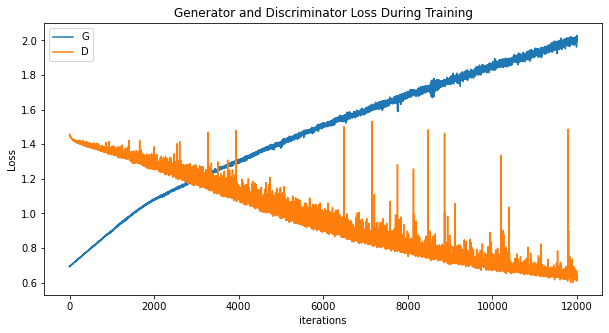

In [67]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('learningCurves_{}.png'.format(modelFlag), bbox_inches='tight',transparent=True)
# plt.show()

## Testing

In [11]:
netD.load_state_dict(torch.load("exp/step002_GANfea_v1_Res18sc/epoch-300.DNet"))

<All keys matched successfully>

In [70]:
del handle
handle = network_add_hook_for_features(backbone, "layer4", features)

features = []


backbone.eval()
for i, (data, _) in enumerate(testloader):
    print(f"Doing {i+1}/{len(testloader)}")
    _ = backbone(data.cuda())

Doing 1/13
Doing 2/13
Doing 3/13
Doing 4/13
Doing 5/13
Doing 6/13
Doing 7/13
Doing 8/13
Doing 9/13
Doing 10/13
Doing 11/13
Doing 12/13
Doing 13/13


In [72]:
print(len(features))
features = torch.cat(features, dim=0)

0


NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

CPU: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/build/aten/src/ATen/RegisterCPU.cpp:21063 [kernel]
CUDA: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/build/aten/src/ATen/RegisterCUDA.cpp:29726 [kernel]
QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/build/aten/src/ATen/RegisterQuantizedCPU.cpp:1258 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradLazy: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXPU: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradMLC: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradHPU: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradNestedTensor: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse1: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse2: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse3: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
Tracer: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/torch/csrc/autograd/generated/TraceType_3.cpp:11220 [kernel]
AutocastCPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:52 [backend fallback]


In [27]:
torch.save(features, "punzoni_res18_features_TEST.pt")

In [73]:
features = torch.load("punzoni_res18_features_TEST.pt")

In [75]:
testset_closeset = BasicDataset(data=features)
testloader = DataLoader(testset_closeset, batch_size=batch_size, shuffle=True, num_workers=1)

In [76]:
len(testset_closeset)

770

In [78]:
outputs_close

array([5.4681915e-01, 5.4998416e-01, 6.9134593e-01, 3.9812735e-01,
       4.8424762e-01, 4.5630208e-01, 4.7543547e-01, 4.4668356e-01,
       2.4908355e-01, 4.7276303e-01, 3.5433048e-01, 4.7740155e-01,
       4.9023098e-01, 3.6746266e-01, 3.9910129e-01, 3.6071619e-01,
       3.9251909e-01, 4.4493988e-01, 3.6710623e-01, 6.2011981e-01,
       1.4551531e-01, 6.0379994e-01, 5.3851563e-01, 4.0199724e-01,
       5.9651732e-01, 4.8539782e-01, 4.8239484e-01, 6.4089108e-01,
       2.8629994e-01, 5.6395477e-01, 6.4832455e-01, 3.9690807e-01,
       4.6671659e-01, 2.9972118e-01, 2.2662856e-01, 4.7201315e-01,
       5.1305634e-01, 4.9492052e-01, 2.5477198e-01, 3.8925600e-01,
       6.0808432e-01, 8.6575466e-01, 3.7611747e-01, 4.6695316e-01,
       3.6368424e-01, 4.9619651e-01, 4.7230676e-01, 5.8354187e-01,
       4.3173307e-01, 9.6092325e-01, 3.6027578e-01, 4.1080546e-01,
       6.4322674e-01, 3.9033142e-01, 3.8406268e-01, 5.6450844e-01,
       4.0884873e-01, 9.2594951e-01, 3.8643524e-01, 4.2078316e

In [77]:
x = next(iter(testloader)).cuda()
(netD(x).view(-1) >= .5).sum().item() / x.size(0)

correct = 0
netD.eval()

outputs_close = []
with torch.no_grad():
    for test_data in testloader:
        output = netD(test_data.cuda()).view(-1)
        outputs_close += [output.cpu()]
        correct += (output >= .5).sum().item()

outputs_close = torch.cat(outputs_close).numpy()

print("Correctly identified items:", correct/len(testloader.dataset))

correct_fake = 0
outputs_open = []
with torch.no_grad():
    for ite in range(10):
        #noise = torch.randn(100, 512, 8, 8, device=device)
        features = []
        noiseimg = torch.randn(100, 3, 256, 256, device=device)
        _ = backbone(noiseimg)
        feats = features[0].cuda()
        assert feats.shape == (100, 512, 8, 8), f"Features shape is {feats.shape}, expected (100, 512, 8, 8)"
        output = netD(feats).view(-1)
        outputs_open.append(output.cpu())
        correct_fake += (output < .5).sum().item()
outputs_open = torch.cat(outputs_open).numpy()

print("Correctly identified fakes:", correct_fake/1000)

roc_score, roc_to_plot = evaluate_openset(outputs_open, outputs_close)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))

Correctly identified items: 0.2922077922077922


IndexError: list index out of range

test con punzoni **grandi**

In [61]:
from PIL import Image

transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet/train/Grandi/"
root_testdata = "../CV_thesis_GiovanniPinna/ImageSet/test/Grandi/"

imgs = [transform(Image.open(os.path.join(root_data,i))) for i in os.listdir(root_data)]
imgs += [transform(Image.open(os.path.join(root_testdata,i))) for i in os.listdir(root_testdata)]
imgs = torch.stack(imgs)

In [62]:
features = []

backbone.eval()
_ = backbone(imgs.cuda())

In [63]:
netD.eval()
output_composti = netD(features[0].cuda()).view(-1).detach().cpu().numpy()

In [64]:
output_composti

array([0.6739283 , 0.73266596, 0.8079949 , 0.7228598 , 0.8557588 ,
       0.8376461 , 0.8098907 , 0.69925076, 0.71038556, 0.6860232 ,
       0.6548502 , 0.75334454, 0.5952091 , 0.792592  , 0.75637764],
      dtype=float32)

test con **no punzoni**

In [34]:
transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet/No_punzoni/"

imgs = [transform(Image.open(os.path.join(root_data,i))) for i in os.listdir(root_data)]
imgs = torch.stack(imgs)

features = []

backbone.eval()
_ = backbone(imgs.cuda())

netD.eval()
outputs_nopunz = netD(features[0].cuda()).view(-1)
outputs_nopunz = outputs_nopunz.detach().cpu().numpy()


In [42]:
outputs_nopunz

array([0.74214154, 0.49442866, 0.81020653, 0.52431124, 0.712851  ,
       0.74693483, 0.6888532 , 0.78641886, 0.7052823 , 0.6950644 ,
       0.5911645 , 0.67522895, 0.69293296, 0.7174795 , 0.43024367],
      dtype=float32)

Text(0.5, 1.0, 'ROC score 0.99939')

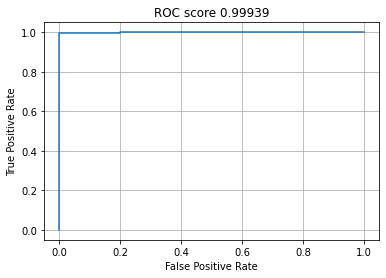

In [40]:
roc_score, roc_to_plot = evaluate_openset(outputs_nopunz, outputs_close)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))

test con **altri punzoni extra**

In [32]:
transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet/extra/"

extra_ds = torchvision.datasets.ImageFolder(root=root_data, transform=transform)
extra_dl = torch.utils.data.DataLoader(extra_ds, batch_size=len(extra_ds), shuffle=False, num_workers=1)

features = []

backbone.eval()
_ = backbone(next(iter(extra_dl))[0].cuda())

netD.eval()
outputs_extra = netD(features[0].cuda()).view(-1)
outputs_extra = outputs_extra.detach().cpu().numpy()


In [44]:
outputs_extra

array([0.83409464, 0.6774761 , 0.86624736, 0.82297736, 0.87356   ,
       0.8917484 , 0.8913916 , 0.71042424, 0.71534586, 0.8441397 ,
       0.88700587, 0.87881744, 0.6180905 , 0.66010606, 0.6900776 ,
       0.7531092 , 0.69765115, 0.74281436, 0.7044879 , 0.5333768 ,
       0.80385584, 0.83393025, 0.8236    , 0.845063  , 0.760179  ,
       0.81495106, 0.69202167, 0.7920756 , 0.8228219 , 0.6675756 ,
       0.66592425, 0.715242  , 0.7470552 , 0.80297697, 0.8000338 ,
       0.77537   , 0.80657244, 0.71206415], dtype=float32)

In [45]:
outputs_close

array([0.9132554 , 0.9037911 , 0.93699205, 0.9202374 , 0.8943375 ,
       0.9079088 , 0.90032095, 0.8961871 , 0.91291976, 0.90685076,
       0.9183301 , 0.8917943 , 0.90291804, 0.8512435 , 0.93417215,
       0.88552254, 0.9110989 , 0.91039324, 0.8990096 , 0.9143753 ,
       0.92082024, 0.90125763, 0.8946731 , 0.8995942 , 0.88718814,
       0.91172254, 0.9087972 , 0.84590894, 0.9132098 , 0.90101564,
       0.91614264, 0.8847292 , 0.92566717, 0.9157165 , 0.8411417 ,
       0.9003595 , 0.89432335, 0.9080792 , 0.87849414, 0.9072918 ,
       0.93162256, 0.8932514 , 0.90817535, 0.8681854 , 0.86253047,
       0.910223  , 0.89075977, 0.8765441 , 0.8762655 , 0.9074947 ,
       0.8874636 , 0.9091248 , 0.8903968 , 0.9217959 , 0.9132398 ,
       0.91766953, 0.89548653, 0.8844044 , 0.88705504, 0.90049857,
       0.91045713, 0.90900785, 0.9291821 , 0.88186353, 0.8918348 ,
       0.8919235 , 0.9179774 , 0.9096839 , 0.9112863 , 0.8920392 ,
       0.8952843 , 0.9016426 , 0.90311986, 0.8914824 , 0.92803

Text(0.5, 1.0, 'ROC score 0.97061')

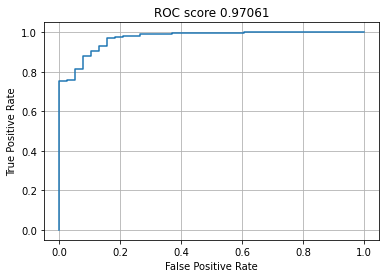

In [66]:
roc_score, roc_to_plot = evaluate_openset(outputs_extra, outputs_close)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))

In [69]:
import sklearn

def mean_ap(outputs1, outputs2):
    y_true = [1] * len(outputs1) + [0] * len(outputs2)
    y_score = np.concatenate([outputs1, outputs2])
    return sklearn.metrics.average_precision_score(y_true, y_score)

mean_ap(outputs_close, outputs_extra)

0.9984245586353054

In [70]:
mean_ap(outputs_close, outputs_nopunz)

0.9999882176370101

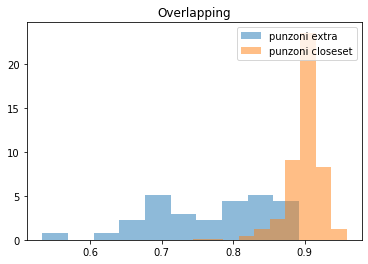

In [54]:
plt.hist(outputs_extra, label="punzoni extra", density=True, alpha=0.5)
plt.hist(outputs_close, label="punzoni closeset", density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

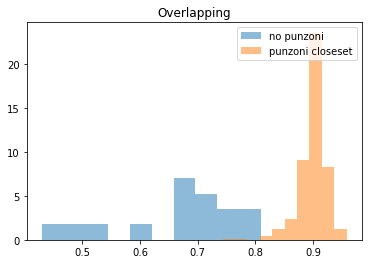

In [55]:
plt.hist(outputs_nopunz, label="no punzoni", density=True, alpha=0.5)
plt.hist(outputs_close, label="punzoni closeset", density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

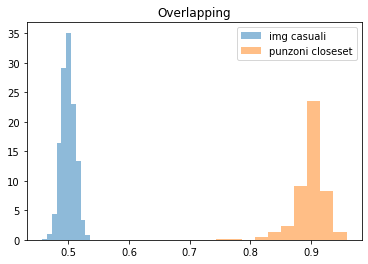

In [56]:
plt.hist(outputs_open, label="img casuali", density=True, alpha=0.5)
plt.hist(outputs_close, label="punzoni closeset", density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

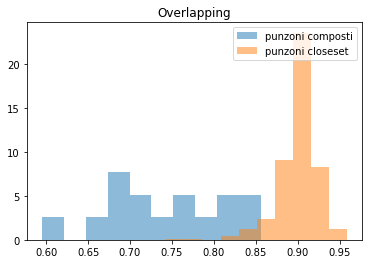

In [65]:
plt.hist(output_composti, label="punzoni composti", density=True, alpha=0.5)
plt.hist(outputs_close, label="punzoni closeset", density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()